# March Madness Model

Hello! Welcome to my first ever Machine Learning Project

March Madness is definitely the most exciting sporting event in the USA. A single elimination tournament provides a tense atmosphere for not only the players, but for the viewers as well. I have been creating brackets and competing in competitions with friends for about 12 years, usually just doing manual research through blogs and data sites like Kenpom and Barttorvik. 

This year, I will attempt to build my bracket using ML techniques that I have learned over the course of the past few months.

My goal in this model is two answer these two main questions  
1. Which teams will have the best chance of winning the tournament?  
2. Which teams, even if not winning the tournament, have the best chance of outperforming their expectation?

![GIF](virginia_purdue.gif)

### Datasets

Data used in this analysis was uploaded by kaggle user andrewsundberg and contains CBB data from years 2015-2020  
https://www.kaggle.com/andrewsundberg/college-basketball-dataset?select=cbb.csv

In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [187]:
cbb = pd.read_csv('cbb.csv')
seed_history = pd.read_csv('MNCAAOverallSeeds.csv')
team_ids = pd.read_csv('MDataFiles_Stage1/MTeamSpellings.csv')

In [188]:
cbb['TEAM'] = cbb['TEAM'].str.lower()

In [189]:
data = pd.merge(cbb, team_ids, left_on='TEAM', right_on='TeamNameSpelling', how='left')
data = pd.merge(data, seed_history, left_on=['TeamID','YEAR'], right_on=['TeamID','Season'], how='left')

## Data Introduction

### Model Goal

From the data shown above, we have a lot of different metrics to attempt to calculate team performance. I envision that this the dataset can produce two different metrics to help with bracket predictions  

1. Overall Winner  
This is the main metric that this project will try to predict. The selection that is worth 50% of all potential points in the ESPN Bracket Challenge, where you will likely not win your bracket unless you select the champion correctly.  
  
  
2. Sleeper Teams  
Teams that probably will not be good enough to win the championship, but are predicted to outperform average performance based on seed. Identifying these teams can give you the extra point boost that can be the difference maker between you and others than predict the same champion

### Choosing a Model

**Input**  
Our data provides us with various team metrics and their past March Madness performance. This will be a **supervised algorithm**

**Output**  
We will be first training to predict an overall winner, using a modified version of the POSTSEASON column to do so. Although POSTSEASON is present as a categorical dataset, it is determined by the number of wins/round that a team achieves in a tournament. This means our output is a **quantitative discrete** output

However, it may be simpler to model with a continuous data output. We are not looking to classify each team as "Sweet 16" or a "Runner-up", we are just trying to find which teams have a best chance of winning the championship based off of past data. Because of this, it is okay for the output to be continuous.

Overall, my first choice at an algorithm is the simple **Linear Regression**

In [190]:
data.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,TeamNameSpelling,TeamID,Season,OverallSeed
0,north carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,36.2,71.7,8.6,2ND,1.0,2016,north carolina,1314.0,2016.0,2.0
1,wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,37.5,59.3,11.3,2ND,1.0,2015,wisconsin,1458.0,2015.0,4.0
2,michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,33.2,65.9,6.9,2ND,3.0,2018,michigan,1276.0,2018.0,11.0
3,texas tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,29.7,67.5,7.0,2ND,3.0,2019,texas tech,1403.0,2019.0,10.0
4,gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,29.0,71.5,7.7,2ND,1.0,2017,gonzaga,1211.0,2017.0,4.0


### Calculating Tourney Wins

This will be the predicted value of Point 1: Overall Winner. The round that each team has reached in March Madness in a given YEAR is represented in the POSTSEASON column. We will want to map this column to # of wins in tourney. We will also want to drop all rows with NA in POSTSEASON, these are the teams that did not qualify for March Madness and will not contribute to our analysis

In [191]:
win_map = {'R68':0, 'R64':0, 'R32':1, 'S16':2, 'E8':3, 'F4':4, '2ND':5, 'Champions':6}
data['MM_Wins'] = data['POSTSEASON'].map(win_map)
data.dropna(inplace = True)

### Calculating Wins over Expected Wins

This will be the predicted value of Point 2: Sleeper Teams. We first calculate a new parameter, Expected Wins, based off a team's seeding

Expected wins calculated from table taken from  
https://bracketodds.cs.illinois.edu/seedadv.html

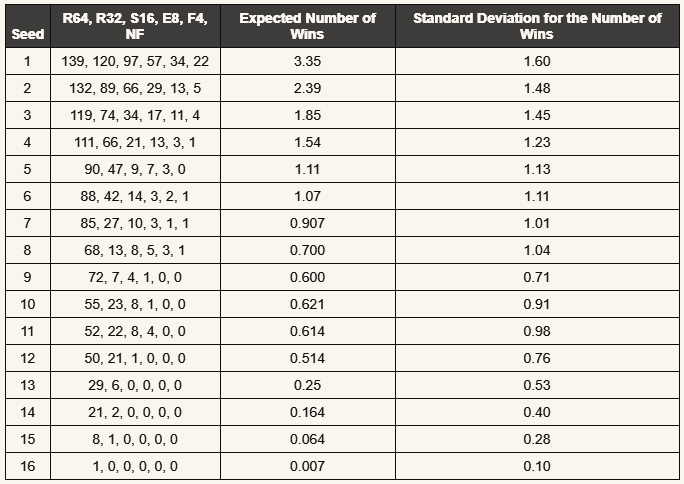

We then calculate the Wins_over_expected by taking the difference between actual MM wins and the Expected wins. The higher the value, the more likely this team will outperform their expected tourney run

In [192]:
expected_wins = pd.DataFrame({'Seed': range(1,17), 'Exp_Wins':[3.35,2.39,1.85,1.54,1.11,1.07,0.907,0.7,0.6,0.621,0.614,0.514,0.25,0.164,0.064,0.007]})
data = pd.merge(data, expected_wins, left_on='SEED', right_on='Seed', how='left')
data['Wins_over_expected'] = data['MM_Wins'] - data['Exp_Wins']

### Data Cleaning

We will want to drop columns that do not relate to Team statistics. Additionally, Win column will also be dropped because our data counts MM wins inside the W column, in which in future predictions will not already be summed in. Exp_Wins column will also need to be dropped because the analyzed value is dependent on it. All features need to be independent from one another in a linear regression model.

In [193]:
data.drop(['W','TEAM','CONF','G','POSTSEASON','SEED','YEAR','TeamNameSpelling','TeamID','Season','Exp_Wins'], axis=1, inplace=True)

We will first get some information about our data

In [194]:
data.shape

(338, 21)

In [195]:
data.dtypes

ADJOE                 float64
ADJDE                 float64
BARTHAG               float64
EFG_O                 float64
EFG_D                 float64
TOR                   float64
TORD                  float64
ORB                   float64
DRB                   float64
FTR                   float64
FTRD                  float64
2P_O                  float64
2P_D                  float64
3P_O                  float64
3P_D                  float64
ADJ_T                 float64
WAB                   float64
OverallSeed           float64
MM_Wins               float64
Seed                    int64
Wins_over_expected    float64
dtype: object

And now check if there is any missing values

In [196]:
data.isnull().sum()

ADJOE                 0
ADJDE                 0
BARTHAG               0
EFG_O                 0
EFG_D                 0
TOR                   0
TORD                  0
ORB                   0
DRB                   0
FTR                   0
FTRD                  0
2P_O                  0
2P_D                  0
3P_O                  0
3P_D                  0
ADJ_T                 0
WAB                   0
OverallSeed           0
MM_Wins               0
Seed                  0
Wins_over_expected    0
dtype: int64

In [197]:
data.describe()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,OverallSeed,MM_Wins,Seed,Wins_over_expected
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,...,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,111.843787,96.984911,0.793780,52.480178,48.019822,17.357396,18.870118,31.143195,28.556509,35.980769,...,51.500000,46.933728,36.130769,33.339053,68.136982,1.432544,34.384615,0.928994,8.763314,-0.020598
std,6.431814,5.265523,0.173445,2.698839,2.389876,1.729227,2.294432,4.163680,2.914647,4.879420,...,3.013461,2.955052,2.501299,2.096446,3.252211,5.058214,19.651866,1.325728,4.672371,0.981179
min,94.800000,84.000000,0.152200,45.600000,39.600000,12.400000,13.700000,17.700000,21.900000,24.400000,...,43.900000,37.700000,29.600000,27.100000,58.400000,-14.500000,1.000000,0.000000,1.000000,-3.350000
25%,107.800000,93.600000,0.733100,50.600000,46.500000,16.300000,17.400000,28.500000,26.400000,32.625000,...,49.500000,45.025000,34.400000,31.900000,66.300000,-1.200000,17.250000,0.000000,5.000000,-0.614000
50%,111.650000,96.400000,0.855550,52.400000,48.100000,17.200000,18.700000,31.300000,28.600000,35.850000,...,51.300000,46.950000,36.100000,33.300000,68.300000,1.600000,34.000000,0.000000,9.000000,-0.070000
75%,116.375000,100.475000,0.915625,54.200000,49.600000,18.475000,20.200000,33.975000,30.600000,39.675000,...,53.375000,49.000000,38.000000,34.700000,70.300000,4.575000,51.000000,1.000000,13.000000,0.386000
max,129.100000,115.600000,0.984200,59.800000,53.800000,23.700000,28.000000,42.000000,35.900000,48.100000,...,61.400000,54.200000,43.400000,38.700000,77.300000,13.100000,68.000000,6.000000,16.000000,3.610000


### Mean Normalization of Data
We want to make sure that the units for all parameters are weighted equally in the analysis. To do so, we will need to perform mean normalization and put the normalized values in a new dataframe: data_normed

In [198]:
data_normed = pd.DataFrame()
means = []
stds = []
for column in data.columns[:-3]:
    means.append(data[column].mean())
    stds.append(data[column].std())
    data_normed[column] = (data[column] - means[-1]) / stds[-1]

In [199]:
data_normed

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,OverallSeed
0,1.781179,-0.395955,0.918560,0.044398,0.033549,-1.131949,-0.292063,2.295278,0.495254,-0.754346,-0.404574,0.796426,-0.789742,-1.371595,1.364665,1.095568,1.416993,-1.647916
1,2.682947,-0.642844,1.049437,0.859563,-0.133824,-2.866828,-1.338074,0.229798,-1.666243,0.044930,-1.798165,1.095086,-0.755901,0.147616,1.984762,-2.717223,1.950779,-1.546144
2,0.397433,-1.250571,0.828618,0.526086,-0.133824,-1.941559,0.274526,-1.355338,-1.254529,-1.082253,-0.474254,1.061902,-0.045254,-0.372114,-0.066328,-0.687834,1.080906,-1.189944
3,0.521814,-2.238127,1.013691,0.377875,-2.100454,0.198125,1.712791,-0.899011,0.049231,-0.631380,0.675459,0.431398,-1.703431,0.147616,-1.735820,-0.195861,1.100676,-1.240830
4,0.926055,-2.029221,1.032141,1.526517,-2.895474,-0.669314,-0.771484,-0.274564,-0.808506,0.618768,-1.014270,1.592853,-2.346398,0.827262,-2.069718,1.034071,1.239065,-1.546144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,-0.100094,-0.433938,0.404852,-0.400238,-0.468569,1.065565,-1.555993,0.662108,-0.431102,-0.815828,-0.892331,0.331844,-0.417498,-1.291636,-0.352527,0.665091,0.092415,-0.477543
334,0.941603,-0.073100,0.659112,-0.474344,0.786726,0.313784,0.536029,1.334590,0.769730,0.229378,0.065763,0.464582,0.834595,-1.691429,0.172171,0.941826,1.159986,-1.189944
335,1.703441,-0.338981,0.893768,1.044828,0.033549,-0.900631,-0.379230,0.109712,0.563873,-0.549403,0.379321,1.294193,-0.755901,0.227574,0.983067,0.203867,1.674001,-1.495258
336,0.863864,-0.471921,0.749630,1.007775,-1.347276,-0.148851,-1.643160,0.229798,-0.877125,-0.323967,-0.805232,0.929164,-0.857422,0.667345,-1.449621,0.019377,0.131955,0.489286


## Model #1, predicting the overall winner

### Baseline Trial

The easiest way someone can create and predict a bracket is to just have everyone from the higher seed advance. Are we able to beat this with our model?  

X - OverallSeed

#### Result
We use root mean squared error (RMSE) to evaluate our model  
RMSE - 0.990

In [200]:
X = data_normed
y = data['MM_Wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
model = LinearRegression()
model.fit(np.array(X_train['OverallSeed']).reshape(-1,1),y_train)
Y_pred = model.predict(np.array(X_test['OverallSeed']).reshape(-1,1))

In [201]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.9901336336463362

<AxesSubplot:ylabel='MM_Wins'>

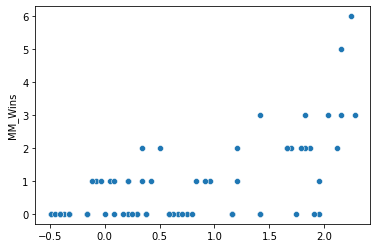

In [202]:
sns.scatterplot(x = Y_pred, y = y_test)

### Trial 1

To start off, I am aiming to perform a simple Linear Regession using all the factors in the our dataframe

X - all columns 
#### Result
RMSE - 0.800  

Our RMSE is smaller than our Baseline trial, suggesting that looking at all the parameters as a whole is more accurate at predict March Madness success than just the seed itself

In [203]:
model.fit(X_train,y_train)
Y_pred = model.predict(X_test)

In [204]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.7881402659628128

<AxesSubplot:ylabel='MM_Wins'>

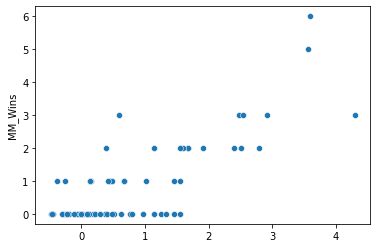

In [205]:
sns.scatterplot(x = Y_pred, y = y_test)

### Trial 2

I believe I am using too many parameters may be overfitting the dataset. In this trial, we will limit to the Top 5 parameters from the earlier correlation observed

X - ADJOE, ADJDE, BARTHAG, WAB, OverallSeed
#### Result
RMSE - 0.787  

Reducing the parameters that we are analyzing with makes the RMSE more accurate, however this does not mean we are at the model's optimal state yet

In [206]:
columns_t2 = ['ADJOE','ADJDE','BARTHAG','WAB']
model.fit(X_train[columns_t2],y_train)
Y_pred = model.predict(X_test[columns_t2])

In [207]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.7785023296595734

<AxesSubplot:ylabel='MM_Wins'>

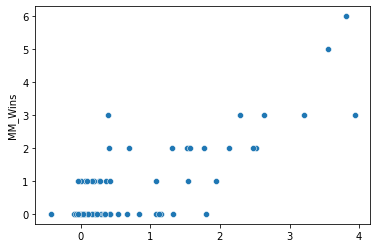

In [208]:
sns.scatterplot(x = Y_pred, y = y_test)

### Model Validation



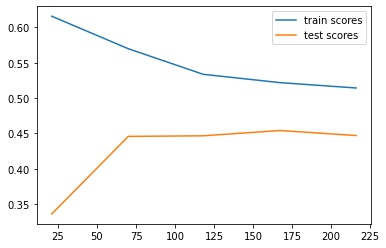

In [209]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train[columns_t2],y_train)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

sns.lineplot(x=train_sizes, y=train_scores_mean, label='train scores')
sns.lineplot(x=train_sizes, y=test_scores_mean, label='test scores')
plt.legend()

Learning Curve shows model that may have HIGH VARIANCE, which means our model may be overfitting. Overfitting is essentially when you algorithm is too tuned to your training data and does not apply to new data very well. The recommended paths forward for a learning curve with this pattern is:  

- Getting more training examples
- Trying smaller sets of features
- Increase regulization in linear regression
- Enabling cross validation in the model

Firstly, getting more training examples is difficult since this dataset is generated externally. Trying a smaller set of features may help, but we have already decreased the number of features earlier down to five. Currently, we are not performing any regularization on our model. The best path forward seems to be to add regularization through enabling cross validation and attempt to find the optimal amount of regularization. To do this, we first split the training set further into a training set and a cross validation set

In [210]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1)

In [211]:
alphas = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56]
train_rmse, valid_rmse = [], []

for alpha in alphas:
    reg_model = Lasso(alpha = alpha)
    reg_model.fit(X_train[columns_t2], y_train)
    train_pred = reg_model.predict(X_train[columns_t2])
    valid_pred = reg_model.predict(X_valid[columns_t2])
    train_rmse.append(mean_squared_error(y_train, train_pred)**(1/2))
    valid_rmse.append(mean_squared_error(y_valid, valid_pred)**(1/2))

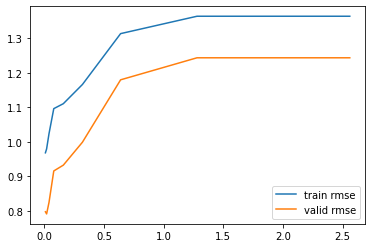

In [212]:
sns.lineplot(x = alphas, y = train_rmse, label='train rmse')
sns.lineplot(x = alphas, y = valid_rmse, label='valid rmse')
plt.legend()

Initially, it was seen that the model was Overfitting. However, it is shown here that adding regularization to the model actually hurts the model and increases the RMSE. Therefore, I am content with sticking with the original model without regularization.

## Model #2, predicting overperformers

The second model will attempt to predict teams that will have a good chance to outperform their seed in the tournament, creating good opportunities for the user to gain additional points in the bracket challenge by selecting these teams to go farther than others

To start, we'll look at the correlation of variation parameters to wins over expected

In [213]:
data.corr()['Wins_over_expected']

ADJOE                 0.086239
ADJDE                -0.109832
BARTHAG               0.059041
EFG_O                 0.062452
EFG_D                -0.057102
TOR                  -0.049616
TORD                  0.107799
ORB                  -0.003153
DRB                   0.102477
FTR                  -0.077534
FTRD                 -0.027766
2P_O                  0.093800
2P_D                 -0.024055
3P_O                 -0.021967
3P_D                 -0.064487
ADJ_T                -0.071241
WAB                   0.024261
OverallSeed          -0.006196
MM_Wins               0.751646
Seed                 -0.007179
Wins_over_expected    1.000000
Name: Wins_over_expected, dtype: float64

At first glance, the correlation between various parameters and wins over expected is a lot weaker than it was when correlating to MM_Wins. This is expected, as there is more volatility to this parameter.  

### Trial 1

We'll first start with all the parameters, like we did last time  

#### Result
RMSE - 0.857

In [214]:
X = data_normed
y = data['Wins_over_expected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
model2 = LinearRegression()
model2.fit(np.array(X_train['OverallSeed']).reshape(-1,1),y_train)
Y_pred = model2.predict(np.array(X_test['OverallSeed']).reshape(-1,1))

In [215]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.8573740097820703

<AxesSubplot:ylabel='Wins_over_expected'>

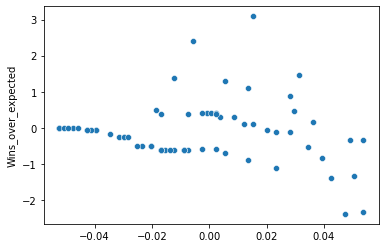

In [216]:
sns.scatterplot(x = Y_pred, y = y_test)

In [217]:
columns_t2 = ['ADJOE','ADJDE','BARTHAG','WAB']
model2.fit(X_train[columns_t2],y_train)
Y_pred = model2.predict(X_test[columns_t2])

In [218]:
mean_squared_error(Y_pred,y_test)**(1/2)

0.8580406989293707

<AxesSubplot:ylabel='Wins_over_expected'>

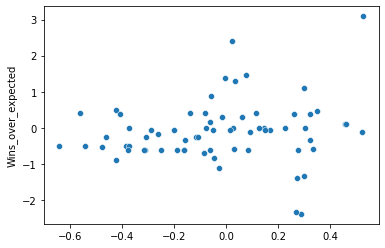

In [219]:
sns.scatterplot(x = Y_pred, y = y_test)

### Model Validation

The scores outputted by the training and test set are very low, and there is little correlation to be found with our current dataset to predict wins over expected. It would be difficult to improve the model with the current dataset that we are using. In the next section, I outline potential paths to adding data that can improve the robustness of this model

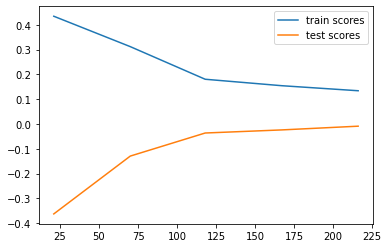

In [220]:
train_sizes, train_scores, test_scores = learning_curve(model2, X_train[columns_t2],y_train)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

sns.lineplot(x=train_sizes, y=train_scores_mean, label='train scores')
sns.lineplot(x=train_sizes, y=test_scores_mean, label='test scores')
plt.legend()

### 2021 Tournament Predictions

Data pulled from:
https://www.kaggle.com/andrewsundberg/college-basketball-dataset?select=cbb21.csv

We will use our established linear regression model to predict which teams have the best chance of winning the 2021 Tournament

In [221]:
data_21 = pd.read_csv('cbb21.csv')

In [222]:
data_21.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0


In [223]:
#only include tournament teams
data_21 = data_21[data_21['SEED'].notnull()]

In [224]:
#apply mean normalization to the new data
data_21_normed = pd.DataFrame() 
col = 0
for column in data.columns[:-4]:
    data_21_normed[column] = (data_21[column] - means[col]) / stds[col]
    col += 1

In [225]:
columns_t2 = ['ADJOE','ADJDE','BARTHAG','WAB']
data_21['MM_wins_21'] = model.predict(data_21_normed[columns_t2])
data_21['MM_wins_21'] = data_21['MM_wins_21'].round(2)
data_21['SEED'] = data_21['SEED'].astype('int')

In [226]:
pd.set_option('display.max_rows', 100)
data_21[['TEAM','SEED','MM_wins_21']].sort_values('MM_wins_21', ascending=False)

,TEAM,SEED,MM_wins_21
3,Gonzaga,1,4.42
6,Houston,2,3.09
1,Baylor,1,2.78
4,Iowa,2,2.58
2,Illinois,1,2.55
0,Michigan,1,2.48
5,Ohio St.,2,2.01
12,Florida St.,4,1.83
7,Alabama,2,1.72
25,Connecticut,7,1.49


Model shows that Gonzaga has the best chance of winning the championship, followed by Houston and Baylor

In [227]:
data_21['wins_over_expected'] = model2.predict(data_21_normed[columns_t2])

In [228]:
data_21[['TEAM','SEED','wins_over_expected']].sort_values('wins_over_expected', ascending=False)

,TEAM,SEED,wins_over_expected
3,Gonzaga,1,1.430489
6,Houston,2,1.176939
1,Baylor,1,0.660680
4,Iowa,2,0.651031
12,Florida St.,4,0.580359
0,Michigan,1,0.433943
25,Connecticut,7,0.423299
20,Texas Tech,6,0.400925
31,Loyola Chicago,8,0.373253
34,Wisconsin,9,0.349831


## MARCH MADNESS 2021 PREDICTIONS

#### Finalists

We look to our model's prediction of highest MM wins to determine the top teams

Winner: Gonzaga
Runner-up: Houston
Other Final 4: Baylor, Michigan

#### Projected Overperforming and Underperforming Teams

Potential overperforming teams:
- Florida St, UConn, Texas Tech, Loyola  

Potential underperforming teams:
- Oklahoma St, Kansas, Arkansas

#### Good Values

We will compare our results to what the public has been choosing using the ESPN Bracketology website. Choosing brackets based off of value by comparing to your public maximizes your chance of winning larger bracket pools
https://fantasy.espn.com/tournament-challenge-bracket/2021/en/whopickedwhom

![who_picked_whom](espn_21.PNG)

1. (2)Houston  
Model predicts that Houston as the second most likely winner. They are only picked by 8.4% of brackets to make it to the championship

2. (7)UConn  
Will face Alabama in the second round, but they are next to each other on the model's predictions. 74% of brackets choose Alabama, while only 15% choose UConn

3. 6 seeds  
(6)USC, (6)San Diego St, and (6)Texas Tech are rated better by the model than their respective 3 seed in the quadrant. The public chooses the 3 seed twice as often as the 6 seed when they face off in the second round

4. (8)Loyola Chicago and (9)Wisconsin  
Both teams are rated higher than their seed, but they face quality 1 seeds in the second round. Could be good value if you are willing to take the risk. Only 7.5% and 7.1% have Loyola and Wisconsin winning two games


## Assessment

#### Finalists
As expected, the model was very chalky(advancing all the higher seeds), but it correctly predicted 3 of the 4 Final Four teams, including Houston which was not a one seed

#### Projected Overperforming and Underperforming Teams
(8)Loyola was able to beat (1)Illinois in one of the largest upsets of the tournament. However, (7)UConn lost in the first round after being identified as a sleeper team. (4)Florida State and (6)Texas Tech did not over or underperform

(4)Oklahoma St and (3)Kansas both underperformed and lost in the second round. (3)Arkansas however made it to the quarterfinals

#### Good Values
1. Although Houston did not make the championship game, they reached the Final Four and still overperformed, which only 17.6% brackets predicted  
2. UConn lost in the first round, this was a mistake the model made
3. (6)USC beat their respective 3 seed and reached the Elite 8. (6)Texas Tech lost in a very close game to (3)Arkansas. (6)San Diego State disappoint and lost in the first round
4. (8)Loyola beat (1)Illinois, but (9)Wisconsin lost to (1)Baylor. Getting 1 out of 2 correct was a success for this

Overall the bracket scored 930 points, placing at the 80th percentile in ESPN

![mm](mm-1.png)

### Potential Future Improvements to Model

Overall, the analysis done in this project is still at a basic level. March madness has a lot of unpredictability and factors that are not captured in the initial dataset that we used. To really hone in and improve the model, there are a few ideas on additional paths to take:

1. Additional Data  
To improve the model, we can gather additional miscellaneous information into our dataset. From my history of reading blogs, additional characteristics of teams that have outperformed expectations in the tournament are:
- Coach's historical record in March Madness
- Seniority of starting lineup (more juniors and seniors)
- Experienced point guard
- Game locations
- Offense Defense balance: an often cited stat of predicted top teams that will fall early is an imbalance of offense and defense
http://harvardsportsanalysis.org/2021/03/balance-wins-championships/

2. Using Pre-Tournament Data  
Data used is calculated post-tournament. Therefore, the games that teams play and win during March Madness are already added into the dataset. This improves metrics for the winning teams and falsely helps the model in predicting March Madness wins. Since a model like this is intended to be used pre-tournament, it would be more accurate to use data for teams without tournament games included.  
  
  
3. Relating Results to Prediction Percentage  
If you compete in a Bracket Challenge, picking the statistically likely winner in every game does not maximize your chance of winning in first place. For example, in 2019 Duke was the overwhelming people's choice favorite to win the championship with about 38% of people picking Duke to win it all on ESPN. Models also thought Duke was the favorite as well, giving them the slight edge over Virginia, which only 8% of people picked to win it all. However, even if Duke wins, you still need to compete with the large number of other people who also picked Duke in other games. Picking a team like Virginia which has a good chance of winning, but is a less popular pick, allows you to compete with less people on other games if in fact they do win. Maximizing your chance of winning a bracket is dependant on the brackets you are competing against.  
  
  
4. Opponent Analysis  
Some teams match up better against other teams and their performance is influenced by which opponents they will face in the tournament. Teams can get weaker opponents if their opponent is overseeded and therefore have a higher chance of winning. This will not matter if the team is expected to perform well or not. Additionally, there are more specific matchup related details about how teams play (f.e. zone or man-to-man defense) that I am not knowledgeable enough to delve into further